AIT-614 : Big Data Essentials
    
Purpose : Project on Sentimental Analysis using Amazon’s Electronics Review Dataset
    
Created By : Team 2 (05/09/2020)
    
            Shivani Ghatge
            Vinaya Chinti

Importing the Libraries 

In [1]:
#import library for pyspark
import pyspark

In [2]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import functions as f
import wordcloud

In [3]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sc = SparkContext(appName='JSON Schema')
sqlContext = SQLContext(sc)

In [4]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [5]:
from pyspark.sql.functions import col
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import year, month, dayofmonth
from pyspark.sql.functions import avg

In [6]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer , StopWordsRemover
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from nltk.stem.snowball import SnowballStemmer
from pyspark.ml.feature import CountVectorizer

In [7]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [8]:
JSON_FILE_PATH  = "C:/Users/15714/Documents/GMU/AIT-614/Project/Electronics_5.json/Electronics_5.json"

In [9]:
#Load json file
elec_json_data = sqlContext.read.json(JSON_FILE_PATH)

In [10]:
#Printing the schema of the Electronics Data
print("Schema of the Electronics Data:")
print(elec_json_data.printSchema())

Schema of the Electronics Data:
root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Capacity:: string (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Colorj:: string (nullable = true)
 |    |-- Colour:: string (nullable = true)
 |    |-- Configuration:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Grip Type:: string (nullable = true)
 |    |-- Item Display Length:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length Range:: 

In [11]:
#Displaying the five records
elec_json_data.show(5)

+----------+-----+-------+--------------------+-----------+--------------+----------------+--------------------+--------------------+--------------+--------+----+
|      asin|image|overall|          reviewText| reviewTime|    reviewerID|    reviewerName|               style|             summary|unixReviewTime|verified|vote|
+----------+-----+-------+--------------------+-----------+--------------+----------------+--------------------+--------------------+--------------+--------+----+
|0151004714| null|    5.0|This is the best ...|09 18, 1999| AAP7PPBU72QFM|    D. C. Carrad|[,,,,,,,,  Hardco...|      A star is born|     937612800|    true|  67|
|0151004714| null|    3.0|Pages and pages o...|10 23, 2013|A2E168DTVGE6SV|             Evy|[,,,,,,,,  Kindle...|A stream of consc...|    1382486400|    true|   5|
|0151004714| null|    5.0|This is the kind ...| 09 2, 2008|A1ER5AYS3FQ9O3|           Kcorn|[,,,,,,,,  Paperb...|I'm a huge fan of...|    1220313600|   false|   4|
|0151004714| null|    

In [12]:
print("Number of Records in the Electronics Dataset:")
elec_json_data.count()

Number of Records in the Electronics Dataset:


6739590

In [13]:
print("Top 10 reviewed products:")
brands=elec_json_data.groupBy("asin").count().sort(col("count").desc()).show(10)

Top 10 reviewed products:
+----------+-----+
|      asin|count|
+----------+-----+
|B003L1ZYYW| 8617|
|B0019HL8Q8| 8160|
|B0019EHU8G| 7777|
|B0015DYMVO| 7380|
|B000VS4HDM| 6802|
|B00DIF2BO2| 6226|
|B00M55C0NS| 6219|
|B00BWF5U0M| 6184|
|B00IVPU7AO| 5987|
|B000BQ7GW8| 5985|
+----------+-----+
only showing top 10 rows



In [14]:
print("Bottom 10 reviewed products:")
elec_json_data.groupBy("asin").count().sort(col("count").asc()).show(10)

Bottom 10 reviewed products:
+----------+-----+
|      asin|count|
+----------+-----+
|B000AV2FHA|    1|
|B0013MYX8E|    1|
|B000YJAWUA|    1|
|B0012KHNZW|    1|
|B0013MYX9S|    1|
|B0015C1RGS|    1|
|B00166G6EG|    1|
|B00125Q77C|    1|
|B000WGS5B8|    1|
|B000Y021Q2|    2|
+----------+-----+
only showing top 10 rows



In [15]:
#Extracting year and monthe from the reviewTime 
elec_json_data_1 = elec_json_data.select('reviewTime', 
            from_unixtime(unix_timestamp('reviewTime', 'MM dd, yyyy')).alias('date'))

elec_json_data_2 = elec_json_data_1.select("reviewTime",
    year("date").alias('year'), 
    month("date").alias('month'), 
    )
elec_json_data_2.show(5)

+-----------+----+-----+
| reviewTime|year|month|
+-----------+----+-----+
|09 18, 1999|1999|    9|
|10 23, 2013|2013|   10|
| 09 2, 2008|2008|    9|
| 09 4, 2000|2000|    9|
| 02 4, 2000|2000|    2|
+-----------+----+-----+
only showing top 5 rows



In [16]:
#Calculate Average Length for Reviews
elec_json_data = elec_json_data.withColumn("word_count", f.size(f.split(elec_json_data['reviewText'], ' ')))
review_length  = elec_json_data.select("overall","word_count").groupBy("overall").agg(avg("word_count"))
review_length.show()

+-------+------------------+
|overall|   avg(word_count)|
+-------+------------------+
|    1.0| 78.83656921212952|
|    4.0| 87.32429248289729|
|    3.0| 89.00920597249105|
|    2.0| 93.45813823057559|
|    5.0|53.828439705780994|
+-------+------------------+



Data Visualizations

Data Visualization for the Distribution of Overall Rating

(array([ 467158.,       0.,       0.,       0.,       0.,  306676.,
              0.,       0.,       0.,       0.,  504781.,       0.,
              0.,       0.,       0., 1137393.,       0.,       0.,
              0., 4323582.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. , 3.2, 3.4,
        3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ]),
 <a list of 20 Patch objects>)

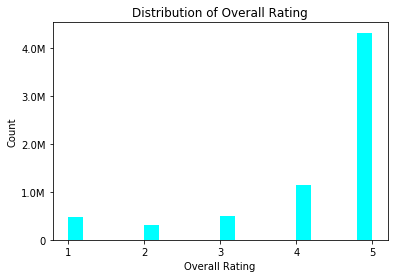

In [17]:
#Visulaization of distribution of Overall Ratings
fig, axes = plt.subplots()
plt.title('Distribution of Overall Rating')
plt.xlabel('Overall Rating')
plt.ylabel('Count')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
axes.xaxis.set_major_locator(loc)
hist(axes, elec_json_data.select("overall"), bins = 20, color=['cyan'])

Data visualization for growth in number of reviews over years

(array([9.500000e+01, 8.600000e+02, 1.811000e+03, 2.718000e+03,
        4.218000e+03, 6.513000e+03, 1.218000e+04, 2.082000e+04,
        5.020100e+04, 8.842800e+04, 1.145910e+05, 1.227880e+05,
        1.784870e+05, 2.969200e+05, 6.454800e+05, 1.034835e+06,
        1.441804e+06, 1.426496e+06, 9.129150e+05, 3.774300e+05]),
 array([1999.  , 1999.95, 2000.9 , 2001.85, 2002.8 , 2003.75, 2004.7 ,
        2005.65, 2006.6 , 2007.55, 2008.5 , 2009.45, 2010.4 , 2011.35,
        2012.3 , 2013.25, 2014.2 , 2015.15, 2016.1 , 2017.05, 2018.  ]),
 <a list of 20 Patch objects>)

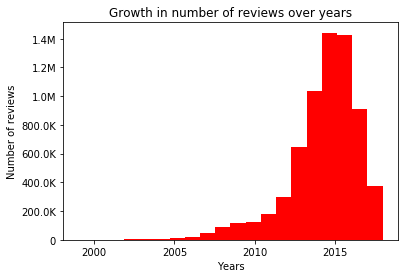

In [18]:
#Visualization for growth in number of reviews over years
fig, axes = plt.subplots()
plt.title('Growth in number of reviews over years')
plt.xlabel('Years')
plt.ylabel('Number of reviews')
loc = plticker.MultipleLocator(base=5.0) # this locator puts ticks at regular intervals
axes.xaxis.set_major_locator(loc)
hist(axes, elec_json_data_2.select("year"), bins = 20, color=['red'])

Data visualization for growth in number of reviews over months

(array([701016.,      0., 585830.,      0., 609053.,      0., 537245.,
             0., 522373.,      0., 502244.,      0.,      0., 559211.,
             0., 554631.,      0., 508119.,      0., 500861.,      0.,
        515307.,      0., 643700.]),
 array([ 1.        ,  1.45833333,  1.91666667,  2.375     ,  2.83333333,
         3.29166667,  3.75      ,  4.20833333,  4.66666667,  5.125     ,
         5.58333333,  6.04166667,  6.5       ,  6.95833333,  7.41666667,
         7.875     ,  8.33333333,  8.79166667,  9.25      ,  9.70833333,
        10.16666667, 10.625     , 11.08333333, 11.54166667, 12.        ]),
 <a list of 24 Patch objects>)

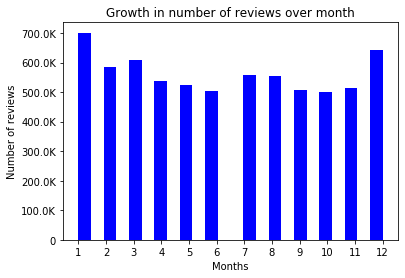

In [19]:
#visualization for growth in number of reviews over months
fig, axes = plt.subplots()
plt.title('Growth in number of reviews over month')
plt.xlabel('Months')
plt.ylabel('Number of reviews')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
axes.xaxis.set_major_locator(loc)
hist(axes, elec_json_data_2.select("month"), bins = 24, color=['blue'])

Data Visualization for Average Text Length vs Ratings

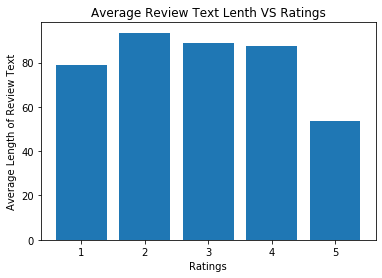

In [21]:
#Visualization for Average Text Length vs Ratings
overall = review_length.toPandas()["overall"].values.tolist()
avg = review_length.toPandas()["avg(word_count)"].values.tolist()
plt.bar(overall,avg)
plt.xlabel('Ratings', fontsize=10)
plt.ylabel('Average Length of Review Text', fontsize=10)
plt.title('Average Review Text Lenth VS Ratings')
plt.show()

Dimentionality Reduction

In [13]:
#For the analysis , we use 2 columns reviewText and overall
review_data = elec_json_data.select("reviewText", "overall")
review_data.show(5)

+--------------------+-------+
|          reviewText|overall|
+--------------------+-------+
|This is the best ...|    5.0|
|Pages and pages o...|    3.0|
|This is the kind ...|    5.0|
|What gorgeous lan...|    5.0|
|I was taken in by...|    3.0|
+--------------------+-------+
only showing top 5 rows



In [14]:
print("Number of Records for the Reviews Data:")
review_data.count()

Number of Records for the Reviews Data:


6739590

In [15]:
#Data Cleaning to check null values
review_data = review_data.where(f.col('reviewText').isNotNull())
review_data = review_data.where(f.col('overall').isNotNull())
print("Number of Records for the Reviews Data after cleaning:")
review_data.count()

Number of Records for the Reviews Data after cleaning:


6738237

Adding the sentiments columns

In [16]:
review_data = review_data.withColumn('sentiment', f.when(f.col('overall') > 3, "pos").when(f.col('overall') == 3, "net")
                       .otherwise("neg"))
review_data.show(5)

+--------------------+-------+---------+
|          reviewText|overall|sentiment|
+--------------------+-------+---------+
|This is the best ...|    5.0|      pos|
|Pages and pages o...|    3.0|      net|
|This is the kind ...|    5.0|      pos|
|What gorgeous lan...|    5.0|      pos|
|I was taken in by...|    3.0|      net|
+--------------------+-------+---------+
only showing top 5 rows



Splitting data into training, validation and testing data

In [17]:
#Divide the data into training , validation and testing data
(training_data,validation_data,testing_data) = review_data.randomSplit([0.7,0.2,0.1], seed=12345)
print("The number of records in training data:",training_data.count())
print("The number of records in Validation data:",validation_data.count())
print("The number of records in testing data:",testing_data.count())

The number of records in training data: 4717030
The number of records in Validation data: 1348531
The number of records in testing data: 672676


Pipeline creation using TF-IDF

In [18]:
#Function to create pipeline for TF-IDF
def pipeline_creation_tfidf():
    #Tokenize the Review Text
    tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
    # Remove stop words
    remover = StopWordsRemover(inputCol='words', outputCol='words_clean')
    #TF IDF 
    hashtf = HashingTF(numFeatures=2**16, inputCol="words_clean", outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
    label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
    pipeline_tfidf = Pipeline(stages=[tokenizer,remover, hashtf, idf, label_stringIdx])
    
    return pipeline_tfidf


Pipeline creation using Bag of words

In [19]:
#Function to create pipeline for Bag of Words
def pipeline_creation_bow():
    #Tokenize the Review Text
    tokenizer = Tokenizer(inputCol="reviewText", outputCol="words")
    # Remove stop words
    remover = StopWordsRemover(inputCol='words', outputCol='words_clean')
    # bag of words count
    countVectors = CountVectorizer(inputCol="words_clean", outputCol="features", vocabSize=10000, minDF=5)
    label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
    pipeline_bow = Pipeline(stages=[tokenizer, remover, countVectors, label_stringIdx])
    
    return pipeline_bow

In [20]:
#Transforming the data according to TF-IDF pipeline
pipeline_tfidf = pipeline_creation_tfidf()
pipeline_fit_tfidf = pipeline_tfidf.fit(training_data)
train_df_tfidf = pipeline_fit_tfidf.transform(training_data)
val_df_tfidf = pipeline_fit_tfidf.transform(validation_data)
test_df_tfidf = pipeline_fit_tfidf.transform(testing_data)

In [31]:
#Transformed Training Data
train_df_tfidf.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|                  tf|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
|

I get my news f...|    5.0|      pos|[, , i, get, my, ...|[, , get, news, d...|(65536,[2423,2705...|(65536,[2423,2705...|  0.0|
| 

Too expensive
...|    5.0|      pos|[, , , too, expen...|[, , , expensive,...|(65536,[2798,3251...|(65536,[2798,3251...|  0.0|
| 

Too expensive
...|    5.0|      pos|[, , , too, expen...|[, , , expensive,...|(65536,[2798,3251...|(65536,[2798,3251...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(65536,[14,611,73...|(65536,[14,611,73...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(

In [32]:
#Transformed validation Data
val_df_tfidf.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|                  tf|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(65536,[14,389,19...|(65536,[14,389,19...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(65536,[14,288,38...|(65536,[14,288,38...|  0.0|
|"".`*.*Five Stars...|    5.0|      pos|["".`*.*five, sta...|["".`*.*five, sta...|(65536,[20004,289...|(65536,[20004,289...|  0.0|
|"4 foot cord" is ...|    1.0|      neg|["4, foot, cord",...|["4, foot, cord",...|(65536,[1903,6891...|(65536,[1903,6891...|  1.0|
|"A good lens with...|    4.0|      pos|["a, good, lens, ...|["a, good, lens, ...|(

In [33]:
#Transformed Testing Data
test_df_tfidf.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|                  tf|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+--------------------+-----+
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(65536,[14,493,54...|(65536,[14,493,54...|  0.0|
| Nice bass respon...|    5.0|      pos|[, nice, bass, re...|[, nice, bass, re...|(65536,[5424,6369...|(65536,[5424,6369...|  0.0|
|                  #1|    5.0|      pos|                [#1]|                [#1]|(65536,[18004],[1...|(65536,[18004],[7...|  0.0|
|$7 protection for...|    5.0|      pos|[$7, protection, ...|[$7, protection, ...|(65536,[3426,7414...|(65536,[3426,7414...|  0.0|
|'Bought several o...|    2.0|      neg|['bought, several...|['bought, several...|(

In [21]:
#Transforming the data according to Bag of Words pipeline
pipeline_bow = pipeline_creation_bow()
pipeline_fit_bow = pipeline_bow.fit(training_data)
train_df_bow = pipeline_fit_bow.transform(training_data)
val_df_bow = pipeline_fit_bow.transform(validation_data)
test_df_bow = pipeline_fit_bow.transform(testing_data)

In [35]:
#Transformed Training Data
train_df_bow.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
|

I get my news f...|    5.0|      pos|[, , i, get, my, ...|[, , get, news, d...|(10000,[0,1,2,6,7...|  0.0|
| 

Too expensive
...|    5.0|      pos|[, , , too, expen...|[, , , expensive,...|(10000,[0,4,311,4...|  0.0|
| 

Too expensive
...|    5.0|      pos|[, , , too, expen...|[, , , expensive,...|(10000,[0,4,311,4...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(10000,[0,2,3,4,6...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(10000,[0,2,3,4,6...|  0.0|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
only showi

In [36]:
#Transformed validation Data
val_df_bow.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(10000,[0,2,4,9,1...|  0.0|
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(10000,[0,2,3,4,6...|  0.0|
|"".`*.*Five Stars...|    5.0|      pos|["".`*.*five, sta...|["".`*.*five, sta...|       (10000,[],[])|  0.0|
|"4 foot cord" is ...|    1.0|      neg|["4, foot, cord",...|["4, foot, cord",...|(10000,[26,118,15...|  1.0|
|"A good lens with...|    4.0|      pos|["a, good, lens, ...|["a, good, lens, ...|(10000,[0,3,4,6,7...|  0.0|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
only showi

In [37]:
#Transformed Testing Data
test_df_bow.show(5)

+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
|          reviewText|overall|sentiment|               words|         words_clean|            features|label|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
| Fuzzy Wuzzy's Su...|    5.0|      pos|[, fuzzy, wuzzy's...|[, fuzzy, wuzzy's...|(10000,[0,2,3,4,6...|  0.0|
| Nice bass respon...|    5.0|      pos|[, nice, bass, re...|[, nice, bass, re...|(10000,[0,6,15,27...|  0.0|
|                  #1|    5.0|      pos|                [#1]|                [#1]|(10000,[5838],[1.0])|  0.0|
|$7 protection for...|    5.0|      pos|[$7, protection, ...|[$7, protection, ...|(10000,[7,13,20,2...|  0.0|
|'Bought several o...|    2.0|      neg|['bought, several...|['bought, several...|(10000,[2,4,6,9,1...|  1.0|
+--------------------+-------+---------+--------------------+--------------------+--------------------+-----+
only showi

In [24]:
#Function for the evaluation of the models
def evaluation(pred_model):
    evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="accuracy")
    accuracy = evaluator_accuracy.evaluate(pred_model)
    evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="f1")
    f1 = evaluator_f1.evaluate(pred_model)
    evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedPrecision")
    precision = evaluator_precision.evaluate(pred_model)
    evaluator_recall =  MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedRecall")
    recall = evaluator_recall.evaluate(pred_model)
    return accuracy,f1,precision,recall

Logistic Regression using TF-IDF

In [39]:
#Logistic Regression with TF-IDF
logistic_regression_tfidf = LogisticRegression(maxIter=100)
logistic_regression_tfidf_model = logistic_regression_tfidf.fit(train_df_tfidf )
pred_logistic_regression_tfidf = logistic_regression_tfidf_model.transform(val_df_tfidf)

In [40]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_logistic_regression_tfidf)
print("The Accuracy of Logistic Regression model on Validation data:")
print(accuracy*100)
print("The F1-Score of Logistic Regression model on Validation data:")
print(f1*100)
print("The Precision of Logistic Regression model on Validation data:")
print(precision*100)
print("The Recall of Logistic Regression model on Validation data:")
print(recall*100)

The Accuracy of Logistic Regression model on Validation data:
86.4524434365988
The F1-Score of Logistic Regression model on Validation data:
84.28066933376067
The Precision of Logistic Regression model on Validation data:
83.54079394490236
The Recall of Logistic Regression model on Validation data:
86.4524434365988


In [41]:
#Evaluation on Testing Data
test_pred_logistic_regression_tfidf  = logistic_regression_tfidf_model.transform(test_df_tfidf )
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_logistic_regression_tfidf)
print("The Accuracy of Logistic Regression model on Testing data:")
print(accuracy*100)
print("The F1-Score of Logistic Regression model on Testing data:")
print(f1*100)
print("The Precision of Logistic Regression model on Testing data:")
print(precision*100)
print("The Recall of Logistic Regression model on Testing data:")
print(recall*100)

The Accuracy of Logistic Regression model on Testing data:
86.49974133163663
The F1-Score of Logistic Regression model on Testing data:
84.35134678444439
The Precision of Logistic Regression model on Testing data:
83.63440836556644
The Recall of Logistic Regression model on Testing data:
86.49974133163663


Logistic Regression using Bag of Words

In [42]:
#Logistic Regression with bag of words
logistic_regression_bow = LogisticRegression(maxIter=100)
logistic_regression_bow_model = logistic_regression_bow.fit(train_df_bow )
pred_logistic_regression_bow = logistic_regression_bow_model.transform(val_df_bow )

In [43]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_logistic_regression_bow)
print("The Accuracy of Logistic Regression model on Validation data:")
print(accuracy*100)
print("The F1-Score of Logistic Regression model on Validation data:")
print(f1*100)
print("The Precision of Logistic Regression model on Validation data:")
print(precision*100)
print("The Recall of Logistic Regression model on Validation data:")
print(recall*100)

The Accuracy of Logistic Regression model on Validation data:
86.59304087188207
The F1-Score of Logistic Regression model on Validation data:
84.0155821198447
The Precision of Logistic Regression model on Validation data:
83.54993005059511
The Recall of Logistic Regression model on Validation data:
86.59304087188208


In [44]:
#Evaluation on Testing Data
test_pred_logistic_regression_bow  = logistic_regression_bow_model.transform(test_df_bow)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_logistic_regression_bow)
print("The Accuracy of Logistic Regression model on Testing data:")
print(accuracy*100)
print("The F1-Score of Logistic Regression model on Testing data:")
print(f1*100)
print("The Precision of Logistic Regression model on Testing data:")
print(precision*100)
print("The Recall of Logistic Regression model on Testing data:")
print(recall*100)

The Accuracy of Logistic Regression model on Testing data:
86.64349553128103
The F1-Score of Logistic Regression model on Testing data:
84.08088912889055
The Precision of Logistic Regression model on Testing data:
83.63198133467901
The Recall of Logistic Regression model on Testing data:
86.64349553128103


Decision Tree using TF-IDF

In [22]:
#Decision Tree with TF-IDF
decision_tree_tfidf = DecisionTreeClassifier(maxDepth = 3)
decision_tree_tfidf_model = decision_tree_tfidf.fit(train_df_tfidf)
pred_decision_tree_tfidf = decision_tree_tfidf_model.transform(val_df_tfidf)

In [25]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_decision_tree_tfidf)
print("The Accuracy of Decision Tree model on Validation data:")
print(accuracy*100)
print("The F1-Score of Decision Tree model on Validation data:")
print(f1*100)
print("The Precision of Decision Tree model on Validation data:")
print(precision*100)
print("The Recall of Decision Tree model on Validation data:")
print(recall*100)

The Accuracy of Decision Tree model on Validation data:
81.77372266562652
The F1-Score of Decision Tree model on Validation data:
74.94841607521757
The Precision of Decision Tree model on Validation data:
73.58787522769545
The Recall of Decision Tree model on Validation data:
81.77372266562652


In [26]:
#Evaluation on Testing Data
test_pred_decision_tree_tfidf  = decision_tree_tfidf_model.transform(test_df_tfidf)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_decision_tree_tfidf)
print("The Accuracy of Decision Tree model on Testing data:")
print(accuracy*100)
print("The F1-Score of Decision Tree model on Testing data:")
print(f1*100)
print("The Precision of Decision Tree model on Testing data:")
print(precision*100)
print("The Recall of Decision Tree model on Testing data:")
print(recall*100)

The Accuracy of Decision Tree model on Testing data:
81.78053029987692
The F1-Score of Decision Tree model on Testing data:
74.95688696358752
The Precision of Decision Tree model on Testing data:
73.50878890324522
The Recall of Decision Tree model on Testing data:
81.78053029987692


Decision Tree using Bag of Words

In [59]:
#Decision Tree with Bag of Words
decision_tree_bow = DecisionTreeClassifier(maxDepth = 3)
decision_tree_bow_model = decision_tree_bow.fit(train_df_bow)
pred_decision_tree_bow = decision_tree_bow_model.transform(val_df_bow)

In [60]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_decision_tree_bow)
print("The Accuracy of Decision Tree model on Validation data:")
print(accuracy*100)
print("The F1-Score of Decision Tree model on Validation data:")
print(f1*100)
print("The Precision of Decision Tree model on Validation data:")
print(precision*100)
print("The Recall of Decision Tree model on Validation data:")
print(recall*100)

The Accuracy of Decision Tree model on Validation data:
81.77572484429353
The F1-Score of Decision Tree model on Validation data:
74.95010530444354
The Precision of Decision Tree model on Validation data:
73.5952300884667
The Recall of Decision Tree model on Validation data:
81.77572484429353


In [61]:
#Evaluation on Testing Data
test_pred_decision_tree_bow  = decision_tree_bow_model.transform(test_df_bow)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_decision_tree_bow)
print("The Accuracy of Decision Tree model on Testing data:")
print(accuracy*100)
print("The F1-Score of Decision Tree model on Testing data:")
print(f1*100)
print("The Precision of Decision Tree model on Testing data:")
print(precision*100)
print("The Recall of Decision Tree model on Testing data:")
print(recall*100)

The Accuracy of Decision Tree model on Testing data:
81.78469277928751
The F1-Score of Decision Tree model on Testing data:
74.96020307530009
The Precision of Decision Tree model on Testing data:
73.52355590588803
The Recall of Decision Tree model on Testing data:
81.78469277928751


Naive Bayes using TF-IDF

In [46]:
#Naive Bayes Algorithm using TF-IDF
naive_bayes_tfidf = NaiveBayes(smoothing=1)
naive_bayes_tfidf_model = naive_bayes_tfidf.fit(train_df_tfidf)
pred_naive_bayes_tfidf = naive_bayes_tfidf_model.transform(val_df_tfidf)

In [47]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_naive_bayes_tfidf)
print("The Accuracy of Naive Bayes model on Validation data:")
print(accuracy*100)
print("The F1-Score of Naive Bayes model on Validation data:")
print(f1*100)
print("The Precision of Naive Bayes model on Validation data:")
print(precision*100)
print("The Recall of Naive Bayes model on Validation data:")
print(recall*100)

The Accuracy of Naive Bayes model on Validation data:
78.25589474769212
The F1-Score of Naive Bayes model on Validation data:
80.48308087461893
The Precision of Naive Bayes model on Validation data:
83.92081579779051
The Recall of Naive Bayes model on Validation data:
78.25589474769212


In [48]:
#Evaluation on Testing Data
test_pred_naive_bayes_tfidf  = naive_bayes_tfidf_model.transform(test_df_tfidf)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_naive_bayes_tfidf)
print("The Accuracy of Naive Bayes model on Testing data:")
print(accuracy*100)
print("The F1-Score of Naive Bayes model on Testing data:")
print(f1*100)
print("The Precision of Naive Bayes model on Testing data:")
print(precision*100)
print("The Recall of Naive Bayes model on Testing data:")
print(recall*100)

The Accuracy of Naive Bayes model on Testing data:
78.24435538059927
The F1-Score of Naive Bayes model on Testing data:
80.48146658671014
The Precision of Naive Bayes model on Testing data:
83.93014360096755
The Recall of Naive Bayes model on Testing data:
78.24435538059929


Naive Bayes using Bag of words

In [49]:
#Naive Bayes Algorithm using Bag of words
naive_bayes_bow = NaiveBayes(smoothing=1)
naive_bayes_bow_model = naive_bayes_bow.fit(train_df_bow)
pred_naive_bayes_bow = naive_bayes_bow_model.transform(val_df_bow)

In [50]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_naive_bayes_bow)
print("The Accuracy of Naive Bayes model on Validation data:")
print(accuracy*100)
print("The F1-Score of Naive Bayes model on Validation data:")
print(f1*100)
print("The Precision of Naive Bayes model on Validation data:")
print(precision*100)
print("The Recall of Naive Bayes model on Validation data:")
print(recall*100)

The Accuracy of Naive Bayes model on Validation data:
83.22871331841833
The F1-Score of Naive Bayes model on Validation data:
82.6926153922537
The Precision of Naive Bayes model on Validation data:
82.2208931045195
The Recall of Naive Bayes model on Validation data:
83.22871331841834


In [51]:
#Evaluation on Testing Data
test_pred_naive_bayes_bow  = naive_bayes_bow_model.transform(test_df_bow)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_naive_bayes_bow)
print("The Accuracy of Naive Bayes model on Testing data:")
print(accuracy*100)
print("The F1-Score of Naive Bayes model on Testing data:")
print(f1*100)
print("The Precision of Naive Bayes model on Testing data:")
print(precision*100)
print("The Recall of Naive Bayes model on Testing data:")
print(recall*100)

The Accuracy of Naive Bayes model on Testing data:
83.24453377257402
The F1-Score of Naive Bayes model on Testing data:
82.71747565503867
The Precision of Naive Bayes model on Testing data:
82.2524575788495
The Recall of Naive Bayes model on Testing data:
83.24453377257402


Random forest using TF-IDF

In [52]:
#Random Forest Algorithm using TF-IDF
random_forest_tfidf = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees = 100,maxDepth = 4,maxBins = 32)
random_forest_tfidf_model = random_forest_tfidf.fit(train_df_tfidf)
pred_random_forest_tfidf = random_forest_tfidf_model.transform(val_df_tfidf)

In [53]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_random_forest_tfidf)
print("The Accuracy of Random Forest model on Validation data:")
print(accuracy*100)
print("The F1-Score of Random Forest model on Validation data:")
print(f1*100)
print("The Precision of Random Forest model on Validation data:")
print(precision*100)
print("The Recall of Random Forest model on Validation data:")
print(recall*100)

The Accuracy of Random Forest model on Validation data:
81.06472895320908
The F1-Score of Random Forest model on Validation data:
72.58719374280196
The Precision of Random Forest model on Validation data:
65.71490280257255
The Recall of Random Forest model on Validation data:
81.06472895320908


In [54]:
#Evaluation on Testing Data
test_pred_random_forest_tfidf  = random_forest_tfidf_model.transform(test_df_tfidf)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_random_forest_tfidf)
print("The Accuracy of Random Forest model on Testing data:")
print(accuracy*100)
print("The F1-Score of Random Forest model on Testing data:")
print(f1*100)
print("The Precision of Random Forest model on Testing data:")
print(precision*100)
print("The Recall of Random Forest model on Testing data:")
print(recall*100)

The Accuracy of Random Forest model on Testing data:
81.10561399544505
The F1-Score of Random Forest model on Testing data:
72.64402771902563
The Precision of Random Forest model on Testing data:
65.78120621578132
The Recall of Random Forest model on Testing data:
81.10561399544505


Random Forest using Bag of Words

In [56]:
#Random Forest Algorithm using Bag of words
random_forest_bow = RandomForestClassifier(labelCol="label",featuresCol="features", numTrees = 100,maxDepth = 4,maxBins = 32)
random_forest_bow_model = random_forest_bow.fit(train_df_bow)
pred_random_forest_bow = random_forest_bow_model.transform(val_df_bow)

In [57]:
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(pred_random_forest_bow)
print("The Accuracy of Random Forest model on Validation data:")
print(accuracy*100)
print("The F1-Score of Random Forest model on Validation data:")
print(f1*100)
print("The Precision of Random Forest model on Validation data:")
print(precision*100)
print("The Recall of Random Forest model on Validation data:")
print(recall*100)

The Accuracy of Random Forest model on Validation data:
81.06472895320908
The F1-Score of Random Forest model on Validation data:
72.58719374280196
The Precision of Random Forest model on Validation data:
65.71490280257255
The Recall of Random Forest model on Validation data:
81.06472895320908


In [58]:
#Evaluation on Testing Data
test_pred_random_forest_bow  = random_forest_bow_model.transform(test_df_bow)
#Evaluation on Validation Data
accuracy,f1,precision,recall = evaluation(test_pred_random_forest_bow)
print("The Accuracy of Random Forest model on Testing data:")
print(accuracy*100)
print("The F1-Score of Random Forest model on Testing data:")
print(f1*100)
print("The Precision of Random Forest model on Testing data:")
print(precision*100)
print("The Recall of Random Forest model on Testing data:")
print(recall*100)

The Accuracy of Random Forest model on Testing data:
81.10561399544505
The F1-Score of Random Forest model on Testing data:
72.64402771902563
The Precision of Random Forest model on Testing data:
65.78120621578132
The Recall of Random Forest model on Testing data:
81.10561399544505
